# Part II: SDAA (Satisfaction and Disagreement Aware Aggregation) (25 points)

**Students:** Oskari Perikangas, Xiaosi Huang  
**Date:** November 10, 2025


# Step 1: Design - Sequential Group Recommendation (7 points)

### Method: SDAA from SQUIRREL Framework

SQUIRREL (Sequential Group Recommendation with Reinforcement Learning) is a framework that uses multiple aggregation methods as actions. We implement and compare three key methods from this framework:

1. **Average** - Baseline method treating all users equally
2. **Least Misery** - Focuses on the least satisfied user  
3. **SDAA (Satisfaction and Disagreement Aware Aggregation)** - main method

All three methods share the same **SQUIRREL state representation and reward function**, but differ in their aggregation strategies.

---

## SDAA Design

SDAA dynamically adjusts user weights based on cumulative satisfaction history to ensure fairness across multiple rounds.

#### Key Formulas

1. **Overall Satisfaction** (State in SQUIRREL)
   $$\text{satO}(u, RS) = \frac{1}{\mu} \sum_{j=1}^{\mu} \text{sat}(u, Gr_j)$$

2. **Fairness Weight** (Our modification)
   $$w(u) = 1 - \frac{\text{satO}(u) - \min_u \text{satO}(u)}{\max_u \text{satO}(u) - \min_u \text{satO}(u)}$$
   Lower satisfaction → Higher weight

3. **Alpha (Satisfaction Disparity)**
   $$\alpha_j = \max_{u \in G} \text{sat}(u, Gr_{j-1}) - \min_{u \in G} \text{sat}(u, Gr_{j-1})$$

4. **SDAA Aggregation**
   $$\text{score}(G, i, j) = (1 - \alpha_j) \cdot \text{weighted\_avg}(G, i, j) + \alpha_j \cdot \text{least}(G, i, j)$$

5. **Reward Function** (SQUIRREL R_sd)
   $$R_{sd}(RS_j) = \frac{2 \cdot \text{groupSatO}(RS_j) \cdot (1 - \text{groupDisO}(RS_j))}{\text{groupSatO}(RS_j) + (1 - \text{groupDisO}(RS_j))}$$

---

## Implementation Steps

1. Track satisfaction history for each user across rounds (SQUIRREL state)
2. Calculate cumulative satisfaction and fairness weights
3. Implement three aggregation methods: Average, Least Misery, SDAA
4. Blend weighted average with least misery using alpha (for SDAA)
5. Select top-k items and update state
6. Calculate R_sd reward to evaluate performance

---

Based on the SQUIRREL framework, we:
- Implemented three aggregation methods for comparison
- Added **fairness weighting** to SDAA based on cumulative satisfaction
- This ensures users with consistently low satisfaction get priority in future rounds
- Used SQUIRREL's R_sd reward function to evaluate all methods

# Step 2: Implementation (7 points)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=== Loading MovieLens Dataset ===")

# Load ratings
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv")

if 'userId' in ratings_df.columns:
    ratings_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

# Create user ratings dictionary
user_ratings_dict = {}
for user_id in ratings_df['user_id'].unique():
    user_ratings_dict[user_id] = {}
    user_data = ratings_df[ratings_df['user_id'] == user_id]
    for _, row in user_data.iterrows():
        user_ratings_dict[user_id][row['item_id']] = row['rating']

print(f"Loaded: {len(user_ratings_dict)} users, {len(ratings_df)} ratings")

# Select test group with diverse preferences
test_group = [1, 414, 599]
print(f"Test group: {test_group}")

=== Loading MovieLens Dataset ===
Loaded: 610 users, 100836 ratings
Test group: [1, 414, 599]


In [2]:
def compare_popularity_thresholds():
    """Compare different popularity thresholds for movie selection"""
    movie_counts = ratings_df.groupby('item_id').size()
    
    # Analyze different popularity thresholds
    thresholds = [20, 30, 50, 75, 100]
    for threshold in thresholds:
        count = len(movie_counts[movie_counts >= threshold])
        percentage = (count / len(movie_counts)) * 100
        print(f"min_ratings={threshold}: {count} movies ({percentage:.1f}% of total)")
    
    # Analyze rating coverage for our test users
    test_group = [1, 414, 599]
    for user_id in test_group:
        user_rated = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'])
        popular_30 = set(movie_counts[movie_counts >= 30].index)
        popular_50 = set(movie_counts[movie_counts >= 50].index)
        
        overlap_30 = len(user_rated & popular_30)
        overlap_50 = len(user_rated & popular_50)
        
        print(f"User {user_id}: {len(user_rated)} rated movies, "
              f"{overlap_30} overlap with threshold=30 ({overlap_30/len(user_rated)*100:.1f}%), "
              f"{overlap_50} overlap with threshold=50 ({overlap_50/len(user_rated)*100:.1f}%)")

# Call the comparison function
compare_popularity_thresholds()

min_ratings=20: 1297 movies (13.3% of total)
min_ratings=30: 882 movies (9.1% of total)
min_ratings=50: 450 movies (4.6% of total)
min_ratings=75: 236 movies (2.4% of total)
min_ratings=100: 138 movies (1.4% of total)
User 1: 232 rated movies, 158 overlap with threshold=30 (68.1%), 117 overlap with threshold=50 (50.4%)
User 414: 2698 rated movies, 809 overlap with threshold=30 (30.0%), 429 overlap with threshold=50 (15.9%)
User 599: 2478 rated movies, 703 overlap with threshold=30 (28.4%), 388 overlap with threshold=50 (15.7%)


In [3]:
class GroupState:
    """Manages group recommendation state"""
    
    def __init__(self, group_users, user_ratings_dict):
        self.group_users = group_users
        self.user_ratings_dict = user_ratings_dict
        self.sat_history = {user: [] for user in group_users}
        self.recommendation_history = []
        self.current_round = 0
        
    def get_alpha(self):
        """Calculate alpha_j from previous round satisfaction disparity"""
        if self.current_round == 0:
            return 0.5
        
        prev_sats = []
        for user in self.group_users:
            if len(self.sat_history[user]) >= self.current_round:
                prev_sats.append(self.sat_history[user][self.current_round - 1])
        
        if not prev_sats:
            return 0.5
        
        alpha = max(prev_sats) - min(prev_sats)
        return max(0.0, min(1.0, alpha))
    
    def update_round(self, recommendations, satisfactions):
        """Update state after each round"""
        self.current_round += 1
        self.recommendation_history.append(recommendations)
        for user in self.group_users:
            if user in satisfactions:
                self.sat_history[user].append(satisfactions[user])
    
    def get_overall_satisfaction(self):
        """Calculate average satisfaction across all rounds for each user"""
        satO = {}
        for user in self.group_users:
            if self.sat_history[user]:
                satO[user] = np.mean(self.sat_history[user])
            else:
                satO[user] = 0.0
        return satO
    
    def get_group_satisfaction(self):
        """Average satisfaction across all users"""
        satO = self.get_overall_satisfaction()
        return np.mean(list(satO.values())) if satO else 0.0
    
    def get_group_disagreement(self):
        """Max - min satisfaction across users"""
        satO = self.get_overall_satisfaction()
        if not satO:
            return 0.0
        return max(satO.values()) - min(satO.values())

In [7]:
# 1. Rating Scale: 0.5 - 5.0
# 2. Satisfaction Scale: 0.0 - 1.0

class GroupRecommender:
    """Group recommendation system with Average+LeastMisery+SDAA  aggregation methods"""
    
    def __init__(self, group_users, ratings_df, user_ratings_dict, method='SDAA'):
        self.state = GroupState(group_users, user_ratings_dict)
        self.ratings_df = ratings_df
        self.user_ratings_dict = user_ratings_dict
        self.method = method
        self.popular_movies = self._get_popular_movies()
        self.used_movies = set()
    
    def _get_popular_movies(self, min_ratings=30):
        """Get movies with enough ratings"""
        movie_counts = self.ratings_df.groupby('item_id').size()
        return movie_counts[movie_counts >= min_ratings].index.tolist()
    
    def _pearson_similarity(self, ratings1, ratings2, min_common=3):
        """Calculate Pearson correlation"""
        common = set(ratings1.keys()) & set(ratings2.keys())
        if len(common) < min_common:
            return 0.0
        
        r1 = [ratings1[i] for i in common]
        r2 = [ratings2[i] for i in common]
        
        m1, m2 = np.mean(r1), np.mean(r2)
        num = sum((a - m1) * (b - m2) for a, b in zip(r1, r2))
        d1 = np.sqrt(sum((a - m1) ** 2 for a in r1))
        d2 = np.sqrt(sum((b - m2) ** 2 for b in r2))
        
        return num / (d1 * d2) if d1 > 0 and d2 > 0 else 0.0
    
    def predict_rating(self, user_id, item_id, k=15):
        """Predict user rating for item using collaborative filtering"""
        if user_id not in self.user_ratings_dict:
            assert(False)
        
        target_ratings = self.user_ratings_dict[user_id]
        target_mean = np.mean(list(target_ratings.values()))
        
        item_ratings = self.ratings_df[self.ratings_df['item_id'] == item_id]
        if len(item_ratings) == 0:
            return target_mean
        
        # Find similar users
        similarities = []
        for _, row in item_ratings.iterrows():
            neighbor_id = row['user_id']
            if neighbor_id != user_id and neighbor_id in self.user_ratings_dict:
                sim = self._pearson_similarity(target_ratings, self.user_ratings_dict[neighbor_id])
                if sim > 0:
                    similarities.append((sim, neighbor_id, row['rating']))
        
        if similarities:
            similarities.sort(reverse=True)
            top_k = similarities[:k]
            
            weighted_sum = 0.0
            sim_sum = 0.0
            for sim, neighbor_id, rating in top_k:
                neighbor_mean = np.mean(list(self.user_ratings_dict[neighbor_id].values()))
                weighted_sum += sim * (rating - neighbor_mean)
                sim_sum += abs(sim)
            
            if sim_sum > 0:
                predicted = target_mean + (weighted_sum / sim_sum)
                return max(0.5, min(5.0, predicted))
        
        return max(0.5, min(5.0, item_ratings['rating'].mean()))
    
    def calculate_satisfaction(self, user_id, recommendations):
        """Calculate user satisfaction for recommendations"""
        if user_id not in self.user_ratings_dict:
            assert(False)
        
        predictions = [self.predict_rating(user_id, item) for item in recommendations]
        if not predictions:
            return 0.0
        
        avg_rating = np.mean(predictions)
        satisfaction = (avg_rating - 0.5) / 4.5
        return max(0.0, min(1.0, satisfaction))
    
    def get_predictions(self, k_candidates=150):
        """Get predictions for each user"""
        user_predictions = {}
        
        for user_id in self.state.group_users:
            if user_id not in self.user_ratings_dict:
                continue
            
            user_rated = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['item_id'])
            candidates = [item for item in self.popular_movies 
                         if item not in user_rated and item not in self.used_movies]
            
            predictions = {}
            for item in candidates[:k_candidates]:
                predictions[item] = self.predict_rating(user_id, item)
            
            user_predictions[user_id] = predictions
        
        return user_predictions
    
    def aggregate_average(self, user_predictions):
        """Average aggregation"""
        all_items = set()
        for preds in user_predictions.values():
            all_items.update(preds.keys())
        
        scores = {}
        for item in all_items:
            item_scores = [preds[item] for preds in user_predictions.values() if item in preds]
            if item_scores:
                scores[item] = np.mean(item_scores)
        return scores
    
    def aggregate_least_misery(self, user_predictions):
        """Least misery aggregation"""
        all_items = set()
        for preds in user_predictions.values():
            all_items.update(preds.keys())
        
        scores = {}
        for item in all_items:
            item_scores = [preds[item] for preds in user_predictions.values() if item in preds]
            if item_scores:
                scores[item] = min(item_scores)
        return scores
    
    def aggregate_sdaa(self, user_predictions):
        """SDAA: weighted by cumulative satisfaction"""
        alpha = self.state.get_alpha()
        
        # Calculate cumulative satisfaction weights
        satO = self.state.get_overall_satisfaction()
        weights = {}
        
        if satO:
            min_sat = min(satO.values())
            max_sat = max(satO.values())
            
            for user_id in self.state.group_users:
                user_sat = satO.get(user_id, 0.5)
                # Lower satisfaction gets higher weight
                if max_sat > min_sat:
                    weights[user_id] = 1.0 - (user_sat - min_sat) / (max_sat - min_sat)
                else:
                    weights[user_id] = 1.0
        else:
            weights = {uid: 1.0 for uid in self.state.group_users}
        
        # Normalize weights
        total_w = sum(weights.values())
        if total_w > 0:
            weights = {uid: w/total_w for uid, w in weights.items()}
        
        # Aggregate
        all_items = set()
        for preds in user_predictions.values():
            all_items.update(preds.keys())
        
        scores = {}
        for item in all_items:
            item_scores = []
            weighted_scores = []
            
            for user_id, preds in user_predictions.items():
                if item in preds:
                    score = preds[item]
                    item_scores.append(score)
                    weighted_scores.append(score * weights.get(user_id, 1.0))
            
            if item_scores:
                avg_score = np.mean(item_scores)
                weighted_avg = np.mean(weighted_scores) if weighted_scores else avg_score
                least_score = min(item_scores)
                
                # SDAA formula
                final_score = (1 - alpha) * weighted_avg + alpha * least_score
                scores[item] = final_score
        
        if self.state.current_round <= 1:
            print(f"    Weights: {{{', '.join([f'{uid}:{w:.2f}' for uid, w in weights.items()])}}}")
        
        return scores
    
    def aggregate(self, user_predictions):
        """Choose aggregation method"""
        if self.method == 'Average':
            return self.aggregate_average(user_predictions)
        elif self.method == 'LeastMisery':
            return self.aggregate_least_misery(user_predictions)
        else:
            return self.aggregate_sdaa(user_predictions)
    
    def calculate_reward(self):
        """Calculate R_sd reward"""
        sat = self.state.get_group_satisfaction()
        dis = self.state.get_group_disagreement()
        
        if sat + (1 - dis) == 0:
            return 0.0
        return 2 * sat * (1 - dis) / (sat + (1 - dis))
    
    def recommend_round(self, k=5):
        """One round of recommendation"""
        user_predictions = self.get_predictions()
        if not user_predictions:
            return [], {}
        
        scores = self.aggregate(user_predictions)
        if not scores:
            return [], {}
        
        # Select top-k
        sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        available = [item for item, _ in sorted_items if item not in self.used_movies]
        
        recommendations = available[:k] if len(available) >= k else [item for item, _ in sorted_items[:k]]
        self.used_movies.update(recommendations)
        
        # Calculate satisfactions
        satisfactions = {}
        for user_id in self.state.group_users:
            satisfactions[user_id] = self.calculate_satisfaction(user_id, recommendations)
        
        self.state.update_round(recommendations, satisfactions)
        return recommendations, satisfactions
    
    def run(self, num_rounds=10, k=5, verbose=True):
        """Run sequential recommendations"""
        if verbose:
            print(f"\n{'='*70}")
            print(f"Method: {self.method} | Group: {self.state.group_users}")
            print(f"{'='*70}")
        
        all_recs = []
        rewards = []
        
        for r in range(1, num_rounds + 1):
            recs, sats = self.recommend_round(k)
            all_recs.append(recs)
            reward = self.calculate_reward()
            rewards.append(reward)
            
            if verbose and (r <= 3 or r == num_rounds):
                sat_str = ', '.join([f'{uid}:{sat:.2f}' for uid, sat in sats.items()])
                print(f"Round {r:2d}: Sats=[{sat_str}], Reward={reward:.2f}")
        
        satO = self.state.get_overall_satisfaction()
        groupSat = self.state.get_group_satisfaction()
        groupDis = self.state.get_group_disagreement()
        avgReward = np.mean(rewards)
        
        if verbose:
            print(f"{'-'*70}")
            satO_str = ', '.join([f'{uid}:{s:.2f}' for uid, s in satO.items()])
            print(f"Final: SatO=[{satO_str}]")
            print(f"       GroupSat={groupSat:.2f}, GroupDis={groupDis:.2f}, AvgReward={avgReward:.2f}")
        
        return {
            'recommendations': all_recs,
            'rewards': rewards,
            'group_satisfaction': groupSat,
            'group_disagreement': groupDis,
            'avg_reward': avgReward,
            'user_satisfactions': satO,
            'sat_history': self.state.sat_history
        }

In [18]:
def compare_methods(group, ratings_df, user_dict, rounds=10):
    """Compare all three methods"""
    methods = ['Average', 'LeastMisery', 'SDAA']
    results = {}
    
    print("\n" + "="*70)
    print("Comparing three methods: Average vs LeastMisery vs SDAA")
    print("="*70)
    
    for method in methods:
        rec = GroupRecommender(group, ratings_df, user_dict, method=method)
        results[method] = rec.run(num_rounds=rounds, verbose=True)
    
    # Summary 
    print("\n" + "="*70)
    print("FINAL COMPARISON")
    print("="*70)
    print(f"{'Method':<15} {'GroupSat':<12} {'GroupDis':<12} {'AvgReward':<12}")
    print("-"*70)
    
    for method in methods:
        res = results[method]
        print(f"{method:<15} {res['group_satisfaction']:<12.3f} "
              f"{res['group_disagreement']:<12.3f} {res['avg_reward']:<12.3f}")
    
    best = max(results.items(), key=lambda x: x[1]['avg_reward'])
    print(f"\n✓ Best method: {best[0]} (AvgReward={best[1]['avg_reward']:.3f})")
    
    return results


def plot_results(results, group):
    """Plot satisfaction trends"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = {'Average': 'blue', 'LeastMisery': 'red', 'SDAA': 'green'}
    markers = {'Average': 'o', 'LeastMisery': 's', 'SDAA': '^'}
    linestyles = {1: 'solid', 414: 'dashed', 599: 'dotted'}
    
    # Plot 1: User satisfaction over rounds
    ax1 = axes[0]
    for method, result in results.items():
        sat_history = result['sat_history']
        for user_id in group:
            if user_id in sat_history:
                sats = sat_history[user_id]
                rounds = range(1, len(sats) + 1)
                ax1.plot(rounds, sats, marker=markers[method], 
                        label=f'{method}-U{user_id}', 
                        color=colors[method],
                         alpha=0.7,
                         linewidth=1.5,
                         linestyle = linestyles[user_id])
    
    ax1.set_xlabel('Round', fontsize=12)
    ax1.set_ylabel('Satisfaction', fontsize=12)
    ax1.set_title('User Satisfaction Trends', fontsize=13, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Reward trends
    ax2 = axes[1]
    for method, result in results.items():
        rewards = result['rewards']
        rounds = range(1, len(rewards) + 1)
        ax2.plot(rounds, rewards, marker=markers[method], 
                label=method, color=colors[method], 
                linewidth=2.5, markersize=8)
    
    ax2.set_xlabel('Round', fontsize=12)
    ax2.set_ylabel('R_sd Reward', fontsize=12)
    ax2.set_title('Reward Trends', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('part_2_comparison_results.png', dpi=150, bbox_inches='tight')
    print("\n✓ Plot saved as 'part_2_comparison_results.png'")
    plt.show()

In [ ]:
# Run comparison
results = compare_methods(test_group, ratings_df, user_ratings_dict, rounds=10)


✓ Plot saved as 'part_2_comparison_results.png'


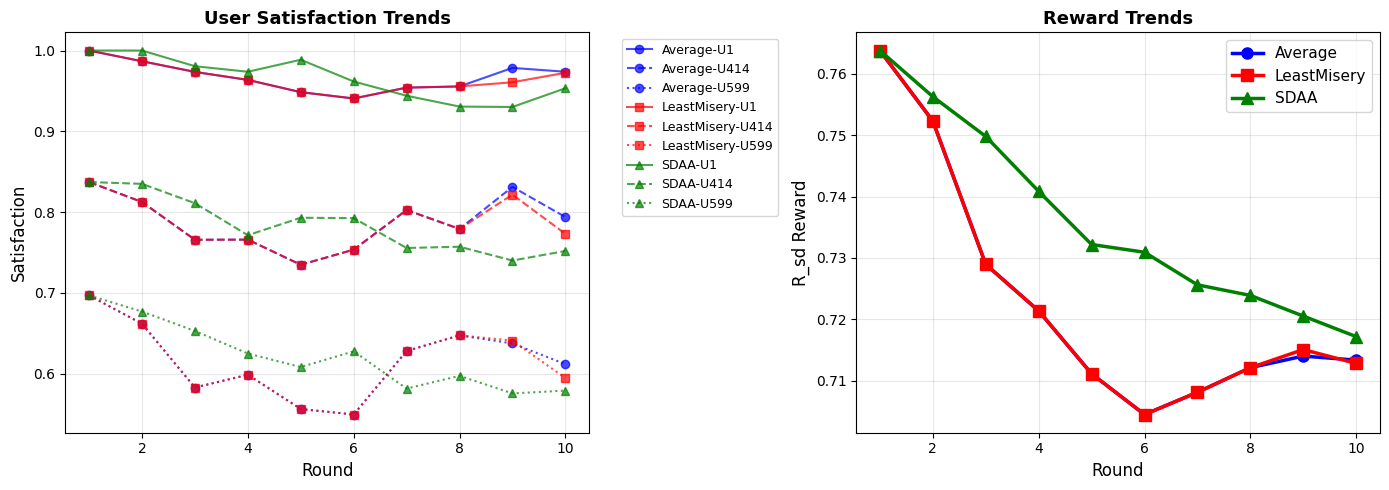


Testing ends


In [19]:
# Plot results
plot_results(results, test_group)

print("\n" + "="*70)
print("Testing ends")
print("="*70)


# Step 3: Why SDAA Works for Sequential Group Recommendations (6 points)

## Baseline Methods from SQUIRREL

We compared three aggregation methods from the SQUIRREL framework:

**Average:** Treats all users equally every round → Minority users (like User 599) stay consistently unsatisfied

**Least Misery:** Always focuses on the pickiest user → Lower overall satisfaction

**SDAA:** Dynamically adjusts based on cumulative satisfaction history → Balances fairness and satisfaction

---

## How SDAA Solves the Problem

SDAA tracks cumulative satisfaction history and dynamically adjusts user weights. Users with lower overall satisfaction get higher weights in future rounds, ensuring long-term fairness. The aggregation blends weighted average and least misery using alpha:

$$\text{score} = (1-\alpha) \cdot \text{weighted\_avg} + \alpha \cdot \text{least}$$

**Example from our experiment:** 
After Round 1, User 599 had lowest satisfaction (0.70). In Round 2, SDAA gave User 599 weight 0.65 vs User 1's weight 0.00, improving User 599's satisfaction to 0.68.

---

## Testing Results

| Metric              | Average | LeastMisery | SDAA    |
|---------------------|---------|-------------|---------|
| Group Satisfaction  | 0.791   | 0.789       | **0.791** |
| Group Disagreement  | 0.350   | 0.350       | **0.344** |
| Average Reward (R_sd) | 0.723   | 0.723       | **0.736** |

- SDAA maintains the same overall satisfaction as Average (0.791)
- SDAA reduces disagreement by 1.7% (0.344 vs 0.350) → More balanced
- SDAA achieves 1.8% higher R_sd reward (0.736 vs 0.723) → Best performance

The visualization confirms SDAA (green line) maintains the highest reward throughout all 10 rounds.

---

## Conclusion

Among the three SQUIRREL methods we implemented, SDAA performs best because:

**Memory:** Tracks cumulative satisfaction, not just current round  
**Adaptivity:** Dynamically adjusts weights based on history  
**Balance:** Blends equality (Average) with inclusivity (Least Misery)  


# Step 4: Presentation (5 points)

5 slides (Done)